## Data preparation and vectorization

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.neighbors import KNeighborsClassifier


Data = np.zeros((400,10304))
cnt=0
paths = ["archive/s"+str(i) for i in range(1,41)]
# looping through the paths and adding flattened images (row matrices) to the Data matrix
for path in paths:
    files = os.listdir(path)
    for file in files:
        img = Image.open(path + "/" + file)
        np_img = np.array(img)
        np_img = np_img.flatten()
        Data[cnt]=np_img
        cnt+=1

# creating the labels vector
labels = np.zeros((400,1))
for i in range(1,41):
    labels[(i-1)*10:i*10] = i

# creating the training set and test set
# syntax explanation : matrix[beginning:end:step]
training_set = Data[0:400:2]
test_set = Data[1:400:2]

# creating the training labels and test labels
training_labels = labels[0:400:2]
test_labels = labels[1:400:2]

print(training_set.shape)
print(test_set.shape)
print(training_labels.shape)
print(test_labels.shape)


(200, 10304)
(200, 10304)
(200, 1)
(200, 1)


## Showing a face sample

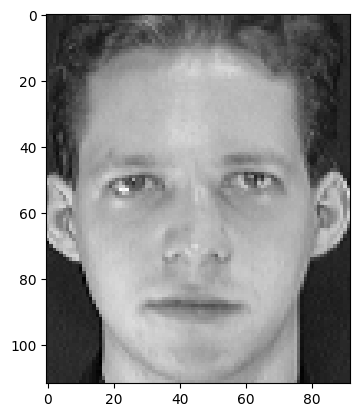

In [3]:
plt.imshow(training_set[0].reshape(112,92),cmap='gray')
plt.show()

## Data preprocessing

In [4]:
def data_processing(training_set,test_set):
    means=np.mean(training_set,axis=0)
    # we need to reshape the means vector to be a row vector to be able to use broadcasting
    means=means.reshape(1,10304)
    print(means.shape)
    centered_training_set=training_set-means
    print("centered_training_set.shape: " + str(centered_training_set.shape))
    centered_test_set=test_set-means
    print("centered_test_set.shape: " + str(centered_test_set.shape))
    # bias=True is used to divide by N instead of N-1 as we told in the lecture
    covariance_matrix=np.cov(centered_training_set.T,bias=True)
    print(covariance_matrix.shape)
    # we use eigh instead of eig because the covariance matrix is symmetric and won't have complex eigenvalues
    eigenvalues,eigenvectors=np.linalg.eigh(covariance_matrix)
    print(eigenvalues.shape)
    print(eigenvectors.shape)

    positions = eigenvalues.argsort()[::-1]
    sorted_eigenvalues = (eigenvalues[positions])
    sorted_eigenvectors = (eigenvectors[:,positions])
        
    return sorted_eigenvalues,sorted_eigenvectors,centered_training_set,centered_test_set



## PCA algorithm

In [5]:
alpha=[0.1 , 0.2 , 0.3 , 0.4, 0.5, 0.6, 0.7, 0.8,0.85, 0.9, 0.95, 0.96 , 0.97 , 0.98 , 0.99]
def get_pca(eigenvalues,eigenvectors, alpha):
    total = sum(eigenvalues)
    r = 0
    current_sum = 0
    while current_sum/total < alpha:
        current_sum += eigenvalues[r]
        r += 1
    new_space = eigenvectors[:, :r]    
    return new_space,r
sorted_eigenvalues,sorted_eigenvectors,centered_training_set,centered_test_set=data_processing(training_set,test_set)
scores=[]
pcs=np.zeros((len(alpha),1))
cnt=0
for i in alpha:
    new_space,pcs[cnt]=get_pca(sorted_eigenvalues,sorted_eigenvectors,i)
    new_training_set = np.dot(centered_training_set, new_space)
    new_test_set = np.dot(centered_test_set, new_space)
    #we use label.ravel() to convert the labels from a column vector to a row vector of shape (200,) instead of (200,1)
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(new_training_set, training_labels.ravel())
    scores.append(knn.score(new_test_set, test_labels.ravel()))
    cnt+=1



(1, 10304)
centered_training_set.shape: (200, 10304)
centered_test_set.shape: (200, 10304)
(10304, 10304)


## showing the first 5 eigen-faces

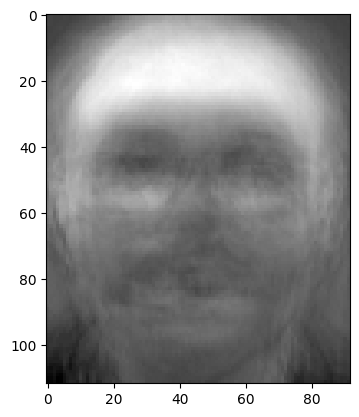

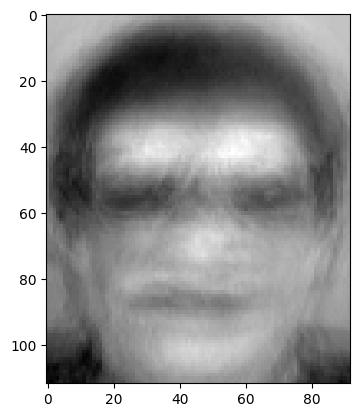

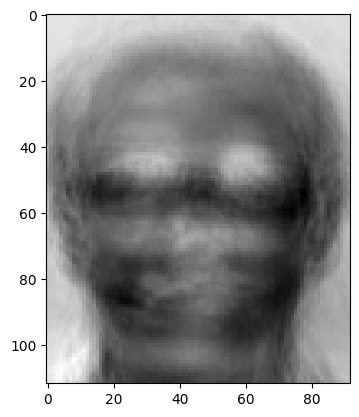

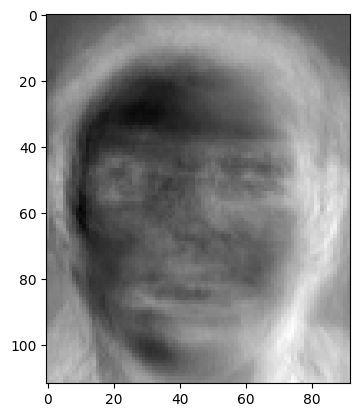

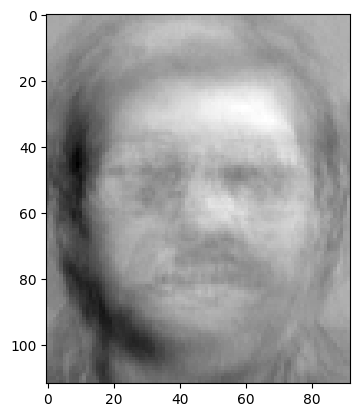

In [ ]:
for i in range(5):
    plt.imshow(sorted_eigenvectors[:,i].reshape(112,92),cmap='gray')
    plt.show()

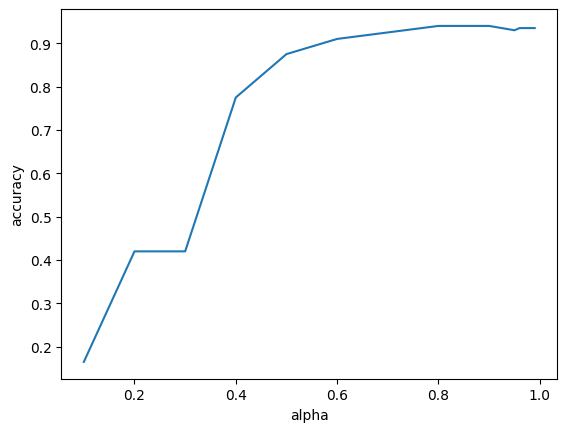

In [ ]:
plt.plot(alpha, scores)
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.show()

according to this figure as alpha increases the accuracy increases 

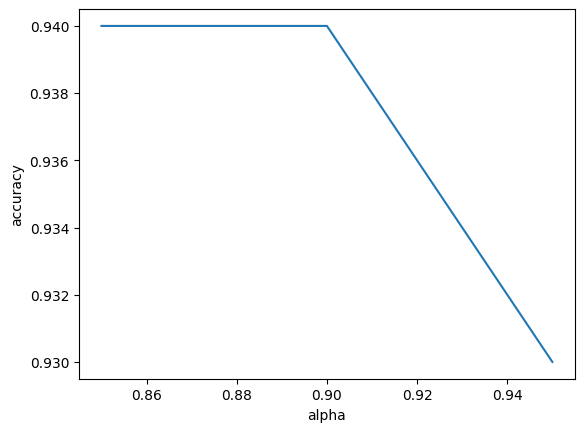

[0.165, 0.42, 0.42, 0.775, 0.875, 0.91, 0.925, 0.94, 0.94, 0.94, 0.93, 0.935, 0.935, 0.935, 0.935]


In [ ]:
plt.plot(alpha[8:11], scores[8:11])
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.show()
print(scores)

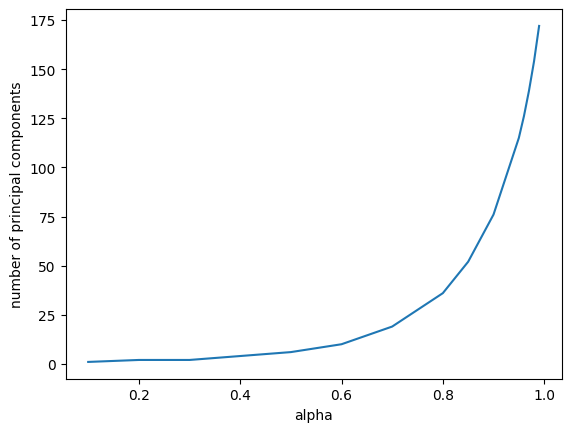

[  1.   2.   2.   4.   6.  10.  19.  36.  52.  76. 115. 126. 139. 154.
 172.]


In [ ]:
plt.plot(alpha, pcs)
plt.ylabel("number of principal components")
plt.xlabel("alpha")
plt.show()
print(pcs.ravel())

## LDA

In [ ]:
# This is a multi-class LDA classifier for face recognition
def LDA(training_set):
    overall_mean = np.mean(training_set, axis=0).reshape(10304,1)
    # Computing the between-class scatter matrix
    S_B = np.zeros((10304,10304))
    S_W = np.zeros((10304,10304))
    for i in range(1,41):
        class_mean = np.mean(training_set[(i-1)*5:i*5], axis=0)
        class_mean = class_mean.reshape(10304,1)
        S_B += 5 * np.dot((class_mean - overall_mean), (class_mean - overall_mean).T)
        centered_data = training_set[(i-1)*5:i*5] - np.mean(training_set[(i-1)*5:i*5], axis=0)
        S_W += np.dot(centered_data.T, centered_data)
    # Computing the eigenvalues and eigenvectors of the generalized eigenvalue problem
    eigenvalues, eigenvectors = np.linalg.eigh(np.linalg.inv(S_W).dot(S_B))
    print("Finished computing eigenvalues and eigenvectors for the LDA")
    
    positions = eigenvalues.argsort()[::-1]
    sorted_eigenvalues = (eigenvalues[positions])
    sorted_eigenvectors = (eigenvectors[:,positions])
    # Taking only the dominant eigenvectors
    new_space = sorted_eigenvectors[:, :39]
    return new_space

In [ ]:
new_space=LDA(training_set)
new_training_set = np.dot(training_set, new_space)
new_test_set = np.dot(test_set, new_space)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(new_training_set, training_labels.ravel())
print("Accuracy for the LDA: " + str(knn.score(new_test_set, test_labels.ravel())))

Finished computing eigenvalues and eigenvectors for the LDA
Accuracy for the LDA: 0.955


## Hyper Parameter tuning for PCA


In [ ]:
k_values=[1,3,5,7]
accuracies=[]
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(new_training_set, training_labels.ravel())
    print(knn.score(new_test_set, test_labels.ravel()))
    accuracies.append(knn.score(new_test_set, test_labels.ravel()))

0.955
0.855
0.8
0.78


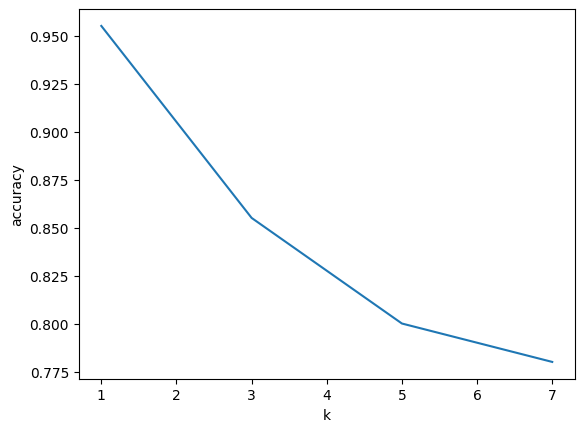

In [ ]:
# Plotting the accuracies for different values of k
plt.plot(k_values, accuracies)
plt.xlabel("k")
plt.ylabel("accuracy")
plt.show()

## Hyper Parameter tuning for LDA

In [ ]:
k_values=[1,3,5,7]
accuracies=[]
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(new_training_set, training_labels.ravel())
    print(knn.score(new_test_set, test_labels.ravel()))
    accuracies.append(knn.score(new_test_set, test_labels.ravel()))

0.955
0.855
0.8
0.78


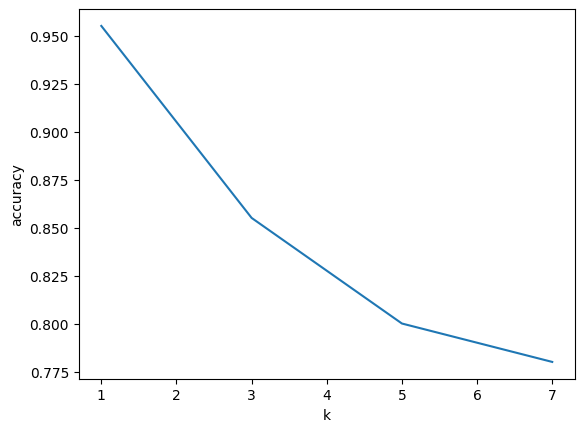

In [ ]:
# Plotting the accuracies for different values of k
plt.plot(k_values, accuracies)
plt.xlabel("k")
plt.ylabel("accuracy")
plt.show()

according to this figure using 1 neighbour is the best choice

## Changing percentage of training and test split

In [ ]:
bonus_training_set = np.zeros((280,10304))
bonus_training_labels = np.zeros((280,1))
bonus_test_set = np.zeros((120,10304))
bonus_test_labels = np.zeros((120,1))
tr=0
ts=0
for i in range(0,400):
    if(i%10<7):
        bonus_training_set[tr]=Data[i]
        bonus_training_labels[tr]=labels[i]
        tr+=1
    else:
        bonus_test_set[ts]=Data[i]
        bonus_test_labels[ts]=labels[i]
        ts+=1                      

## applying PCA on these splits

In [ ]:
bonus_sorted_eigenvalues,bonus_sorted_eigenvectors,bonus_centered_training_set,bonus_centered_test_set=data_processing(bonus_training_set,bonus_test_set)
k_values=[1,3,5,7]
bonus_accuracies=[]

bonus_pcs=np.zeros((len(alpha),1))
bonus_scores=[]
cnt=0
for i in alpha:
    bonus_new_space,bonus_pcs[cnt]=get_pca(bonus_sorted_eigenvalues,bonus_sorted_eigenvectors,i)
    bonus_new_training_set = np.dot(bonus_centered_training_set, bonus_new_space)
    bonus_new_test_set = np.dot(bonus_centered_test_set, bonus_new_space)
    #we use label.ravel() to convert the labels from a column vector to a row vector of shape (200,) instead of (200,1)
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(bonus_new_training_set, bonus_training_labels.ravel())
    bonus_scores.append(knn.score(bonus_new_test_set, bonus_test_labels.ravel()))
    cnt+=1


(1, 10304)
centered_training_set.shape: (280, 10304)
centered_test_set.shape: (120, 10304)
(10304, 10304)
(10304,)
(10304, 10304)


##  applying LDA with these splits

In [ ]:
new_space=LDA(bonus_training_set)
new_training_set = np.dot(bonus_training_set, new_space)
new_test_set = np.dot(bonus_test_set, new_space)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(new_training_set, bonus_training_labels.ravel())
print("Accuracy for the LDA: " + str(knn.score(new_test_set, bonus_test_labels.ravel())))

Finished computing eigenvalues and eigenvectors for the LDA
Accuracy for the LDA: 0.9583333333333334


the accuracy  has increase from 95.5% to 95.83%

In [ ]:
print(bonus_training_set.shape)
print(bonus_test_set.shape)
print(new_training_set.shape)
print(new_test_set.shape)

(280, 10304)
(120, 10304)
(280, 39)
(120, 39)


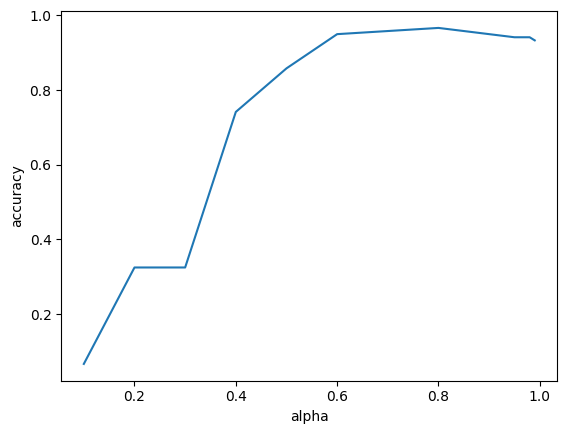

In [ ]:
plt.plot(alpha,bonus_scores)
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.show()

### plotting alpha and pcs

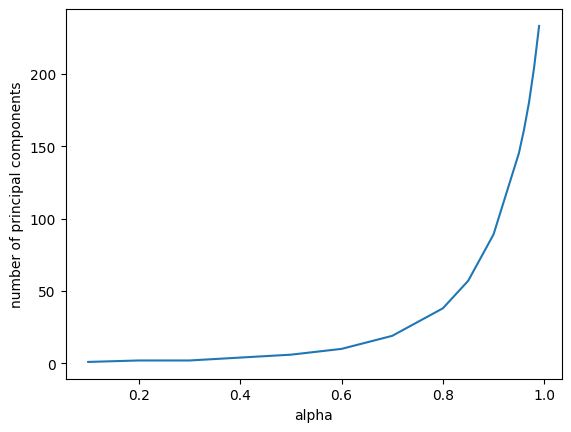

[  1.   2.   2.   4.   6.  10.  19.  38.  57.  89. 145. 161. 180. 204.
 233.]


In [ ]:
plt.plot(alpha, bonus_pcs)
plt.ylabel("number of principal components")
plt.xlabel("alpha")
plt.show()
print(bonus_pcs.ravel())

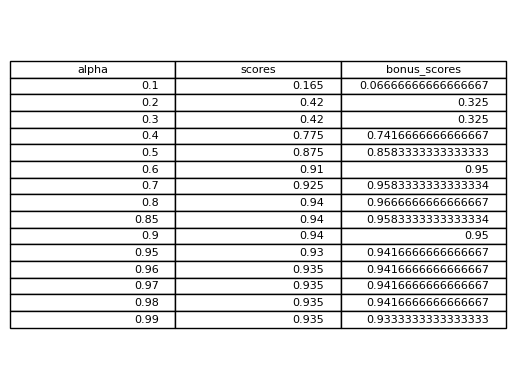

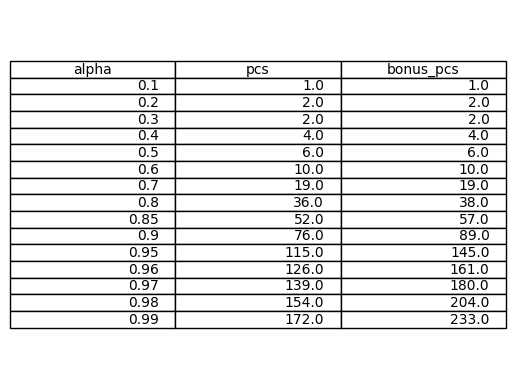

In [ ]:
size=bonus_pcs.shape[0]
plt.axis('off')
plt.table(cellText=[[alpha[i],scores[i],bonus_scores[i]] for i in range(size)], colLabels=['alpha','scores','bonus_scores'], loc='center')
plt.show()

pcs=pcs.ravel()
bonus_pcs=bonus_pcs.ravel()
plt.axis('off')
plt.table(cellText=[[alpha[i],pcs[i],bonus_pcs[i]] for i in range(size)], colLabels=['alpha','pcs','bonus_pcs'], loc='center')
plt.show()

as shown accuracies have increased by splitting data int 70% training split and 30% test split and number of principle components increases for each alpha

In [42]:
from sklearn.decomposition import PCA as RandomizedPCA
rpca = RandomizedPCA(n_components=52, svd_solver='randomized')
rpca.fit(training_set)
new_training_set = rpca.transform(training_set)
new_test_set = rpca.transform(test_set)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(new_training_set, training_labels.ravel())
print("Accuracy for the randomized PCA: " + str(knn.score(new_test_set, test_labels.ravel())))


Accuracy for the randomized PCA: 0.945


In [12]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=52, kernel='poly')
kpca.fit(training_set)
new_training_set = kpca.transform(training_set)
new_test_set = kpca.transform(test_set)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(new_training_set, training_labels.ravel())
print("Accuracy for the Kernel PCA: " + str(knn.score(new_test_set, test_labels.ravel())))

Accuracy for the Kernel PCA: 0.935


In [14]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=52, kernel='rbf')
kpca.fit(training_set)
new_training_set = kpca.transform(training_set)
new_test_set = kpca.transform(test_set)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(new_training_set, training_labels.ravel())
print("Accuracy for the Kernel PCA: " + str(knn.score(new_test_set, test_labels.ravel())))

Accuracy for the Kernel PCA: 0.025


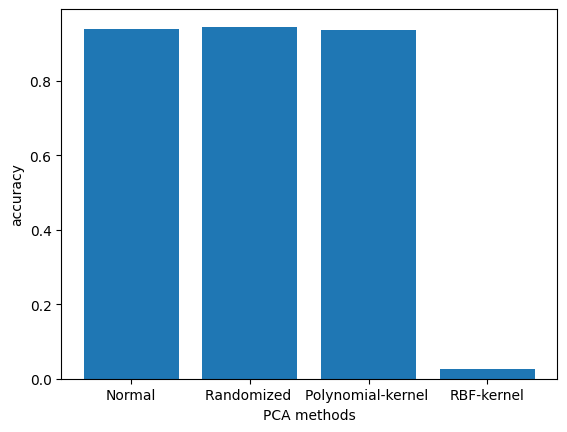

In [16]:
accuracies_names=["Normal","Randomized ","Polynomial-kernel ","RBF-kernel"]
accuracies=[0.94,0.945,0.935,0.025]
plt.bar(accuracies_names,accuracies)
plt.xlabel("PCA methods")
plt.ylabel("accuracy")
plt.show()


In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
lda.fit(training_set, training_labels.ravel())
new_training_set = lda.transform(training_set)
new_test_set = lda.transform(test_set)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(new_training_set, training_labels.ravel())
print("Accuracy for the shrinkage LDA: " + str(knn.score(new_test_set, test_labels.ravel())))


Accuracy for the shrinkage LDA: 0.95


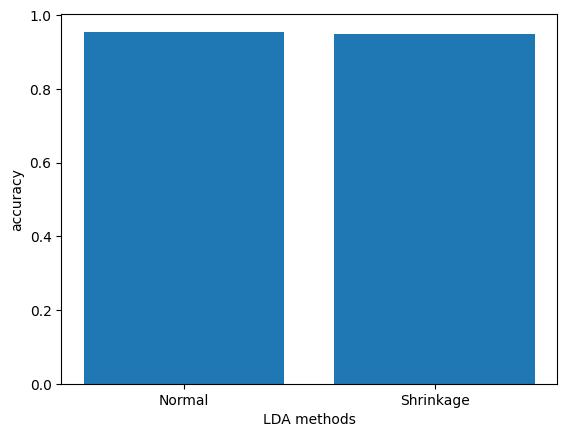

In [19]:
accuracies_names=["Normal","Shrinkage"]
accuracies=[0.955,0.95]
plt.bar(accuracies_names,accuracies)
plt.xlabel("LDA methods")
plt.ylabel("accuracy")
plt.show()